In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import permutation_test_score
%config InlineBackend.figure_format='retina'


tract_info = pd.read_csv('data/tract_info.csv')
cortices = list(set(tract_info.cortex))

df_areas = pd.read_csv('data/tract_cross-sectional-areas.csv')
df_func  = pd.read_csv('data/system_functional-surface-areas.csv')
df = pd.merge(df_areas, df_func, on='id')
df = df.dropna()


system_colors = {
    'ant':'#003a7d',
    'body':'#4ecc8d',
    'post':'#c700ff'
}
systems = list(system_colors.keys())

display(df)

,id,AF-L__Hipp-L_0,AF-L__Hipp-L_1,CG-L__CC__Hipp-L,CG-L__CC-isthmus__POS1-L_0,AF-L__Hipp-L_2,CC__Hipp-R,CG-L__CC__POS2-L,CC__CC-splenium__ProS-R,CG-L__CC__V3A-L,...,IFO-R__PHA2-R_1,CC__V2-R,CC__CC-isthmus__CG-R__Hipp-R,AF-L__Hipp-R_4,IFO-R__ST-OCC-R__AF-L__Hipp-R,AF-L__FX-L__Hipp-L_1,CC__ILF-L__PHA3-L,ant_mm,body_mm,post_mm
0,HCD0001305,12.492314,45.948628,30.660106,0.637349,19.315874,4.014349,1.271122,1.694577,0.874725,...,7.823236,1.347300,0.315052,41.666059,6.953296,13.126395,1.840375,256.14548,422.27676,808.23694
3,HCD0022919,8.145933,38.417246,49.448629,0.972176,29.207022,3.494819,0.726577,1.947841,0.597824,...,16.929673,0.988442,0.322050,42.797630,10.479829,2.328043,1.489937,405.00270,541.88690,628.05250
4,HCD0026119,47.245156,49.228183,31.566864,0.984765,13.406142,2.268093,1.408846,1.103316,0.236176,...,7.925952,1.088180,0.000000,63.691935,9.128708,14.516532,0.143935,897.40640,235.50615,258.15283
5,HCD0029630,18.910583,35.862008,28.360636,1.957182,23.951802,4.613003,0.949462,1.606128,0.190845,...,12.999035,0.152666,0.233721,66.658482,5.008882,16.921338,0.270847,369.14197,427.27820,623.78250
6,HCD0031617,13.109362,43.667242,37.036654,1.113447,23.056369,2.428588,1.284650,1.090314,0.632497,...,13.617065,1.020533,0.534859,50.812406,22.198136,2.779623,1.468580,636.76540,288.44785,591.81494
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
534,HCD2978386,5.760724,12.941554,17.122665,0.944236,12.814879,3.854952,0.631824,1.498024,1.165525,...,7.399635,0.992633,0.942437,22.557615,0.272407,0.388397,1.709457,120.51685,432.10270,1088.40370
535,HCD2982579,19.673321,23.038178,28.887326,1.138459,20.916148,1.796392,1.766133,1.027417,0.415696,...,10.887571,0.642886,0.049749,51.279669,11.141329,8.097025,0.466146,1106.01100,122.30182,231.89955
536,HCD2987185,7.963692,28.980848,38.550812,1.627673,18.021602,3.807203,2.101928,1.793933,1.358675,...,14.275613,1.624296,0.647867,39.495069,5.517050,2.153107,3.150470,457.19315,298.15857,812.17920
537,HCD2990073,20.310970,36.525024,26.188280,1.494767,18.840424,5.715446,1.209990,2.415746,0.639721,...,8.720110,2.129984,1.202670,30.424541,8.439853,2.999365,1.450308,269.19410,775.08203,435.16020


In [ ]:

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', RidgeCV(alphas=np.logspace(-3,5,10)))
])

# Note: minimum possible p-value with n_permutations=500 is .002
all_results = {}
for cortex in cortices:

    tracts = tract_info[tract_info.cortex == cortex]['label']

    results = {}
    for system in systems:

        r2, r2_null, p_val = permutation_test_score(
            pipeline,
            X=df[tracts],
            y=df[f'{system}_mm'],
            n_permutations=500
        )

        print(f'{cortex} {system}: R2={r2:.3f}, p={p_val:.3f}')
        results[f'{system}_r2']      = r2
        results[f'{system}_r2_null'] = r2_null
        results[f'{system}_p']       = p_val

    all_results[cortex] = results


Posterior_Cingulate ant: R2=-0.021, p=0.567
Posterior_Cingulate body: R2=0.005, p=0.006
Posterior_Cingulate post: R2=0.039, p=0.002
Dorsal_Stream_Visual ant: R2=-0.009, p=0.214
Dorsal_Stream_Visual body: R2=-0.010, p=0.236
Dorsal_Stream_Visual post: R2=0.059, p=0.002
Early_Visual ant: R2=-0.009, p=0.226
Early_Visual body: R2=-0.009, p=0.226
Early_Visual post: R2=0.097, p=0.002
Ventral_Stream_Visual ant: R2=-0.012, p=0.313
Ventral_Stream_Visual body: R2=-0.010, p=0.253


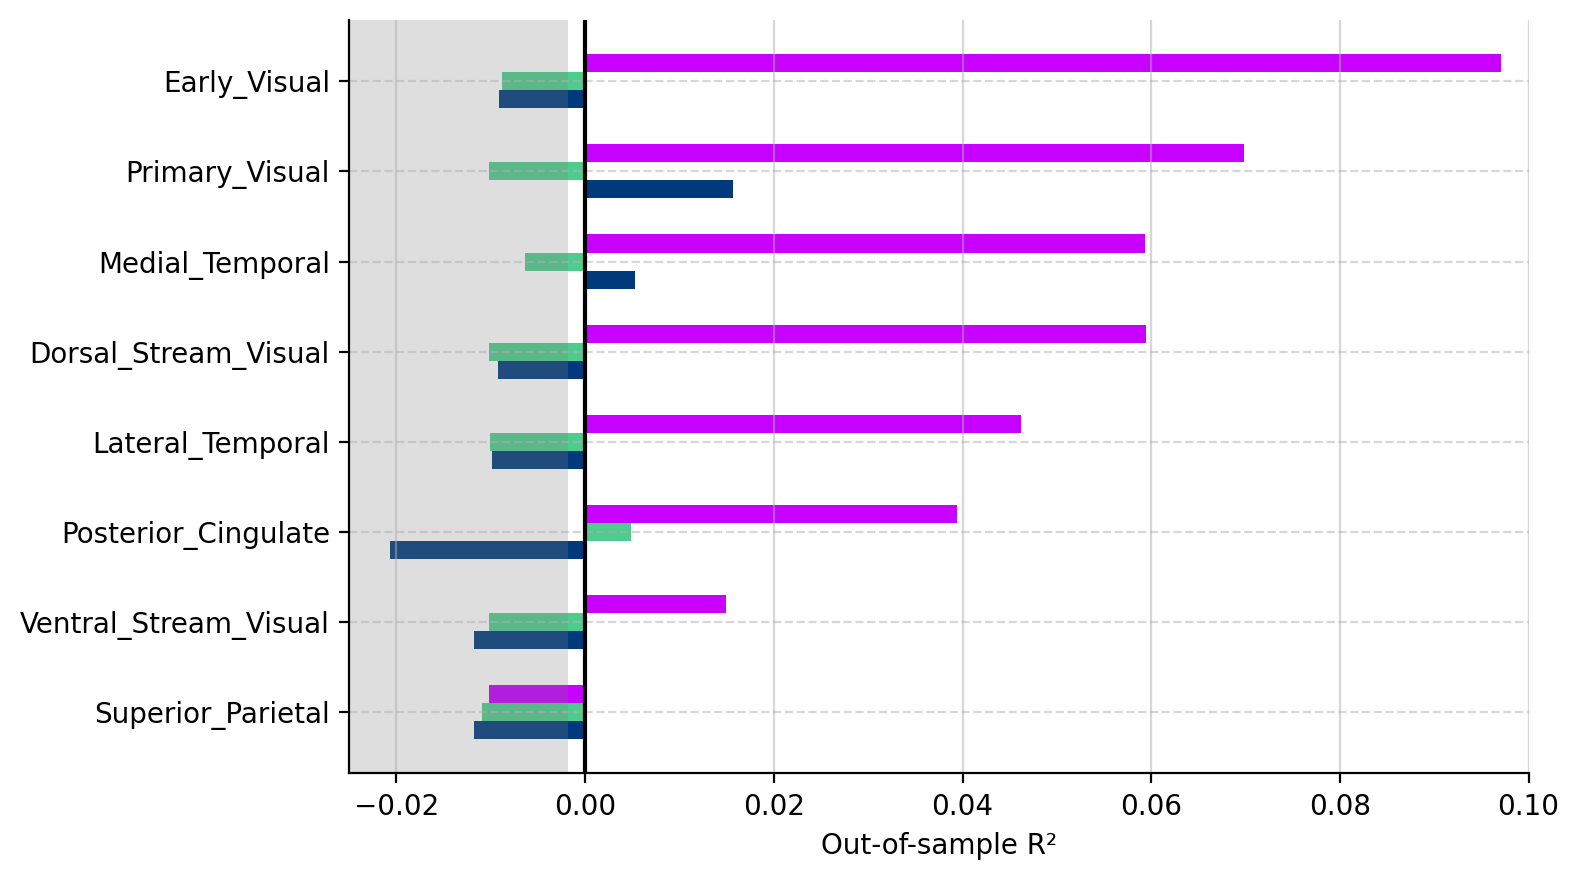

In [ ]:

# Plot results.
mean_r2 = {c: np.mean([all_results[c][f'{s}_r2'] for s in systems]) for c in all_results}
cortex_labels = sorted(all_results.keys(), key=lambda c: mean_r2[c])

n_cortex = len(cortex_labels)
n_systems = len(systems)

# Bar positions
bar_height = 0.2
y_pos = np.arange(n_cortex)  # one y position per cortex

fig, ax = plt.subplots(figsize=(8, 4.5))

for i, s in enumerate(systems):

    r2_vals = [all_results[c][f'{s}_r2'] for c in cortex_labels]
    ax.barh(
        (y_pos + i*bar_height),
        r2_vals,
        height=bar_height,
        color=system_colors[s],
        ecolor='black', capsize=0,
        label=s.capitalize()
    )

# Set y-axis
ax.set_yticks(y_pos + bar_height*(n_systems-1)/2, cortex_labels)
ax.set_xlabel('Out-of-sample R²')
ax.grid(axis='y', linestyle='--', alpha=.5)
ax.grid(axis='x', linestyle='-', alpha=.5)

null_distributions = np.hstack([all_results[cortex][f'{system}_r2_null'] for cortex, system in zip(cortex_labels, systems)])

ax.axvspan(
    np.percentile(null_distributions, .025),
    np.percentile(null_distributions, 97.5),
    facecolor='tab:gray', alpha=.25
)

ax.set_xlim([-.025, .1])
ax.axvline(0, color='k')
sns.despine()
plt.tight_layout()
plt.show()